##### feature set 5 chromosomes 1 to 22, inclusive 

## In this notebook:

* single input dataframe 
* using feature set 5
* random forest, n=100, balanced 

In [1]:
import torch
import pandas as pd
import numpy as np

# using sklearn goodies
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import plot_roc_curve
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split, LeaveOneGroupOut
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix, recall_score
from statistics import stdev

## pull in pickled dataframe:
df = pd.read_pickle("./pickled/chr1-22_set5_mc.pkl")




print("shape before", df.shape)
df = df.replace({'.': 0})
df = df.dropna()
print("shape after dropping all data with score = '.'", df.shape)


## Map labels to 1/0 and remove Unkn
clinvar_labels={
    'Pathogenic': 1,
    'Likely_pathogenic': 1,
    'Pathogenic/Likely_pathogenic': 1,
    'Benign/Likely_benign': 0,
    'Likely_benign': 0,
    'Benign': 0
}

df = df.replace({'-': 0}) 
print("shape after dropping Unk", df.shape)
df.tail()

shape before (65424, 15)
shape after dropping all data with score = '.' (65424, 15)
shape after dropping Unk (65424, 15)


aapos codonpos  Polyphen2_HVAR_pred  \
chr pos      ref alt                                        
22  50731130 G   T     1671        1                    0   
    50731142 T   C     1669        1                    0   
    50731202 G   A     1695        1                    0   
    50731245 T   C     1709        2                    0   
    50744827 A   G      296        1                    1   

                         GenoCanyon_score LINSIGHT    RVIS_ExAC  \
chr pos      ref alt                                              
22  50731130 G   T      0.999999998793117        0            0   
    50731142 T   C      0.999999812995836        0            0   
    50731202 G   A      0.999999996800745        0            0   
    50731245 T   C      0.999999743036315        0            0   
    50744827 A   G    2.02108863558055E-6        0  0.475882698   

                          ExAC_cnv.score  SORVA_LOF_MAF0.005_HetOrHom  \
chr pos      ref alt                                                    
22  50731130 G   T    -0.046967084155657                          0.0   
    50731142 T   C    -0.046967084155657                          0.0   
    50731202 G   A    -0.046967084155657                          0.0   
    50731245 T   C    -0.046967084155657                          0.0   
    50744827 A   G     -2.42357860216279                          0.0   

                      position  Problematic  Mutation<1kb  Mutation<5kb  \
chr pos      ref alt                                                      
22  50731130 G   T    50731130            1             6             9   
    50731142 T   C    50731142            1             6             9   
    50731202 G   A    50731202            1             6             9   
    50731245 T   C    50731245            1             6             9   
    50744827 A   G    50744827            0             3             3   

                      Mutation<10kb  Mutation<30kb  Mutation<100kb  
chr pos      ref alt                                                
22  50731130 G   T               19             77             116  
    50731142 T   C               19             77             116  
    50731202 G   A               18             77             116  
    50731245 T   C               18             77             116  
    50744827 A   G                8             41             127

In [2]:

dfc = df.copy()
dfc = dfc.reset_index()
group_by_chr = dfc['chr'].to_numpy()
y = dfc.pop('Problematic')
X = dfc

## Extract the group-by-chromosome column:
logo = LeaveOneGroupOut()
print("To split by chromosomes into %s groups" % logo.get_n_splits(groups = group_by_chr))


## Setup forest:
forest = RandomForestClassifier(n_estimators=1000, random_state=42, class_weight='balanced')

# store results for all held out chromosomes
metric_by_test_chr = {}
all_accuracy = []
all_recall = []
all_precision = []
all_F1 = []

def get_proportion(labels):
    count = np.count_nonzero(labels == 1)
    length = len(labels)
    return {'count': count, 'length': length, 'proportion': count/length}

#### fit a model for each chromosome:

for train_index, test_index in logo.split(X, y, group_by_chr):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    test_chrom = X_test.iloc[0]['chr']
    

    X_train = X_train.set_index(['chr','pos', 'ref', 'alt'])
    X_test = X_test.set_index(['chr','pos', 'ref', 'alt'])

    forest.fit(X_train, y_train)
    y_true = y_test.to_numpy()
    y_pred = forest.predict(X_test)
    
    ## Calculate metrics for each held out chr, as well as all
    print("Testing chromosome %s" % test_chrom) ## hah, at least I'm sure it works now 
    print("Accuracy:", accuracy_score(y_true, y_pred))
    recall = recall_score(y_true, y_pred, average=None)[0]
    precision = precision_score(y_true, y_pred, average=None)[0]
    F1 = 2 * (precision * recall) / (precision + recall)
    
    all_accuracy.append(accuracy_score(y_true, y_pred))
    all_recall.append(recall)
    all_precision.append(precision)
    all_F1.append(F1)
    print("Completed chromosome. \n\n")
    
    
    metric_by_test_chr[test_chrom] = {
        "Shape, train:": X_train.shape,
        "Shape, test:": X_test.shape,
        "Confusion matrix:": confusion_matrix(y_true, y_pred),
        "Accuracy:": accuracy_score(y_true, y_pred),
        "Recall TP/(TP+FN):": recall,
        "Precision TP/(TP+FP):": precision,
        "Proportion of Pathogenic, train": get_proportion(y_train),
        "Proportion of Pathogenic, test": get_proportion(y_test),
        "Proportion of Pathogenic, predicted": get_proportion(y_pred),
        "F1": F1
        
    }

    

To split by chromosomes into 22 groups
Testing chromosome 1
Accuracy: 0.7876871880199667
Completed chromosome. 


Testing chromosome 2
Accuracy: 0.7754996776273372
Completed chromosome. 


Testing chromosome 3
Accuracy: 0.8657199800697558
Completed chromosome. 


Testing chromosome 4
Accuracy: 0.8044856167723062
Completed chromosome. 


Testing chromosome 5
Accuracy: 0.8217404396266185
Completed chromosome. 


Testing chromosome 6
Accuracy: 0.7782500885582714
Completed chromosome. 


Testing chromosome 7
Accuracy: 0.8452524038461539
Completed chromosome. 


Testing chromosome 8
Accuracy: 0.7718120805369127
Completed chromosome. 


Testing chromosome 9
Accuracy: 0.8326166060205095
Completed chromosome. 


Testing chromosome 10
Accuracy: 0.7970358172087278
Completed chromosome. 


Testing chromosome 11
Accuracy: 0.8540359682141363
Completed chromosome. 


Testing chromosome 12
Accuracy: 0.5138888888888888
Completed chromosome. 


Testing chromosome 13
Accuracy: 0.8754325259515571
Complet

In [3]:
## Add global metrics
def str_av_std(values):
    return str(sum(values)/len(values)) + ' +/- ' + str(stdev(values))

metric_by_test_chr['all'] = {
    "Shape, whole dataset:": X.shape,
    "Accuracy:": str_av_std(all_accuracy),
    "Recall TP/(TP+FN):": str_av_std(all_recall),
    "Precision TP/(TP+FP):": str_av_std(all_precision),
    "Proportion of Pathogenic, whole dataset": get_proportion(y),
    "F1": str_av_std(all_F1)    
}

In [4]:
import pprint as pp
pp.pprint(metric_by_test_chr)




{1: {'Accuracy:': 0.7876871880199667,
     'Confusion matrix:': array([[ 804,  781],
       [ 495, 3930]]),
     'F1': 0.5575589459084604,
     'Precision TP/(TP+FP):': 0.6189376443418014,
     'Proportion of Pathogenic, predicted': {'count': 4711,
                                             'length': 6010,
                                             'proportion': 0.7838602329450916},
     'Proportion of Pathogenic, test': {'count': 4425,
                                        'length': 6010,
                                        'proportion': 0.7362728785357737},
     'Proportion of Pathogenic, train': {'count': 42853,
                                         'length': 59414,
                                         'proportion': 0.7212609822600734},
     'Recall TP/(TP+FN):': 0.5072555205047319,
     'Shape, test:': (6010, 14),
     'Shape, train:': (59414, 14)},
 2: {'Accuracy:': 0.7754996776273372,
     'Confusion matrix:': array([[ 719, 1554],
       [ 187, 5295]]),
     'F1'

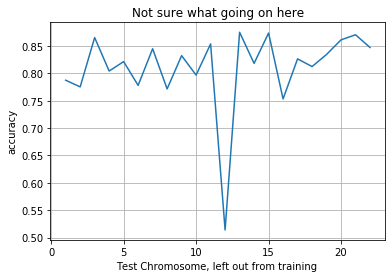

In [6]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

# Data for plotting
t = range(1,23)
s = all_accuracy

fig, ax = plt.subplots()
ax.plot(t, s)

ax.set(xlabel='Test Chromosome, left out from training ', ylabel='accuracy',
       title='Not sure what going on here')
ax.grid()

fig.savefig("test.png")
plt.show()